<a href="https://colab.research.google.com/github/manmeet3/Brain-Tumor-Anomaly-Detection-and-Segmentation/blob/master/colabs/TumorSegmentation/BRATS_Segmentation_UNet3D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install itk

     |████████████████████████████████| 16.6MB 172kB/s 
     |████████████████████████████████| 20.2MB 99kB/s 
     |████████████████████████████████| 70.1MB 40kB/s 
     |████████████████████████████████| 15.0MB 213kB/s 
     |████████████████████████████████| 53.6MB 141kB/s 
     |████████████████████████████████| 94.7MB 113kB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install itkwidgets

     |████████████████████████████████| 3.4MB 8.0MB/s 
     |████████████████████████████████| 276kB 47.9MB/s 
     |████████████████████████████████| 2.2MB 52.4MB/s 
     |████████████████████████████████| 112kB 55.6MB/s 
     |████████████████████████████████| 870kB 46.3MB/s 


# Libraries

In [ ]:
import json
import numpy as np
import pandas as pd
import nibabel as nib

import torch

# For visualization
import itk
import itkwidgets
from ipywidgets import interact, interactive, IntSlider, ToggleButtons
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')

In [ ]:
image_folder = "/content/drive/MyDrive/Masters_Project/Datasets/medicaldecathlon/Task01_BrainTumour/imagesTr/"
img_name = 'BRATS_001.nii.gz'
image_obj = nib.load(image_folder + img_name)

image_data = image_obj.get_fdata()
type(image_data)

numpy.ndarray

In [ ]:
# Get the image shape

height, width, depth, channels = image_data.shape
print(f"The image object has the following dimensions: \nheight: {height} \nwidth: {width} \ndepth: {depth} \nchannels: {channels}")

The image object has the following dimensions: 
height: 240 
width: 240 
depth: 155 
channels: 4


Plotting Layer 100 Channel 3 of Image


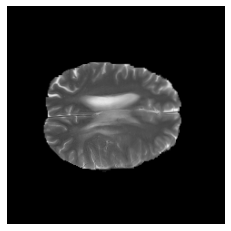

In [ ]:
# Select random layer number

layer = 56           #@param {type:"slider", min:0, max:100, step:1}
channel =  1    #@param {type:"slider", min:0, max:3, step:1}
print(f"Plotting Layer {layer} Channel {channel} of Image")
plt.imshow(image_data[:, :, layer, channel], cmap='gray')
plt.axis('off');

In [ ]:

# Define a function to visualize the Brain MRI

def explore_3dimage(layer):
    plt.figure(figsize=(10, 5))
    channel = 3
    plt.imshow(image_data[:, :, layer, channel], cmap='gray');
    plt.title('Explore Layers of Brain MRI', fontsize=20)
    plt.axis('off')
    return layer

# Run the ipywidgets interact() function to explore the data
interact(explore_3dimage, layer=(0, image_data.shape[2] - 1));

interactive(children=(IntSlider(value=77, description='layer', max=154), Output()), _dom_classes=('widget-inte…

# Load file and Extract the labels as a numpy array¶


In [ ]:
label_folder = '/content/drive/MyDrive/Masters_Project/Datasets/medicaldecathlon/Task01_BrainTumour/labelsTr/'
label = 'BRATS_001.nii.gz'
label_obj = nib.load(label_folder+label)

label_array = label_obj.get_fdata()
type(label_array)

numpy.ndarray

In [ ]:
# Extract the shape of the labels data

height, width, depth = label_array.shape
print(f"Dimensions of labels data array: \nheight: {height} \nwidth: {width} \ndepth: {depth}")
print(f'\nWith the unique values: {np.unique(label_array)}')
print("""\nCorresponding to the following label categories: 
0: for normal 
1: for edema
2: for non-enhancing tumor 
3: for enhancing tumor""")

Dimensions of labels data array: 
height: 240 
width: 240 
depth: 155

With the unique values: [0. 1. 2. 3.]

Corresponding to the following label categories: 
0: for normal 
1: for edema
2: for non-enhancing tumor 
3: for enhancing tumor


# Visualize Labeled Data


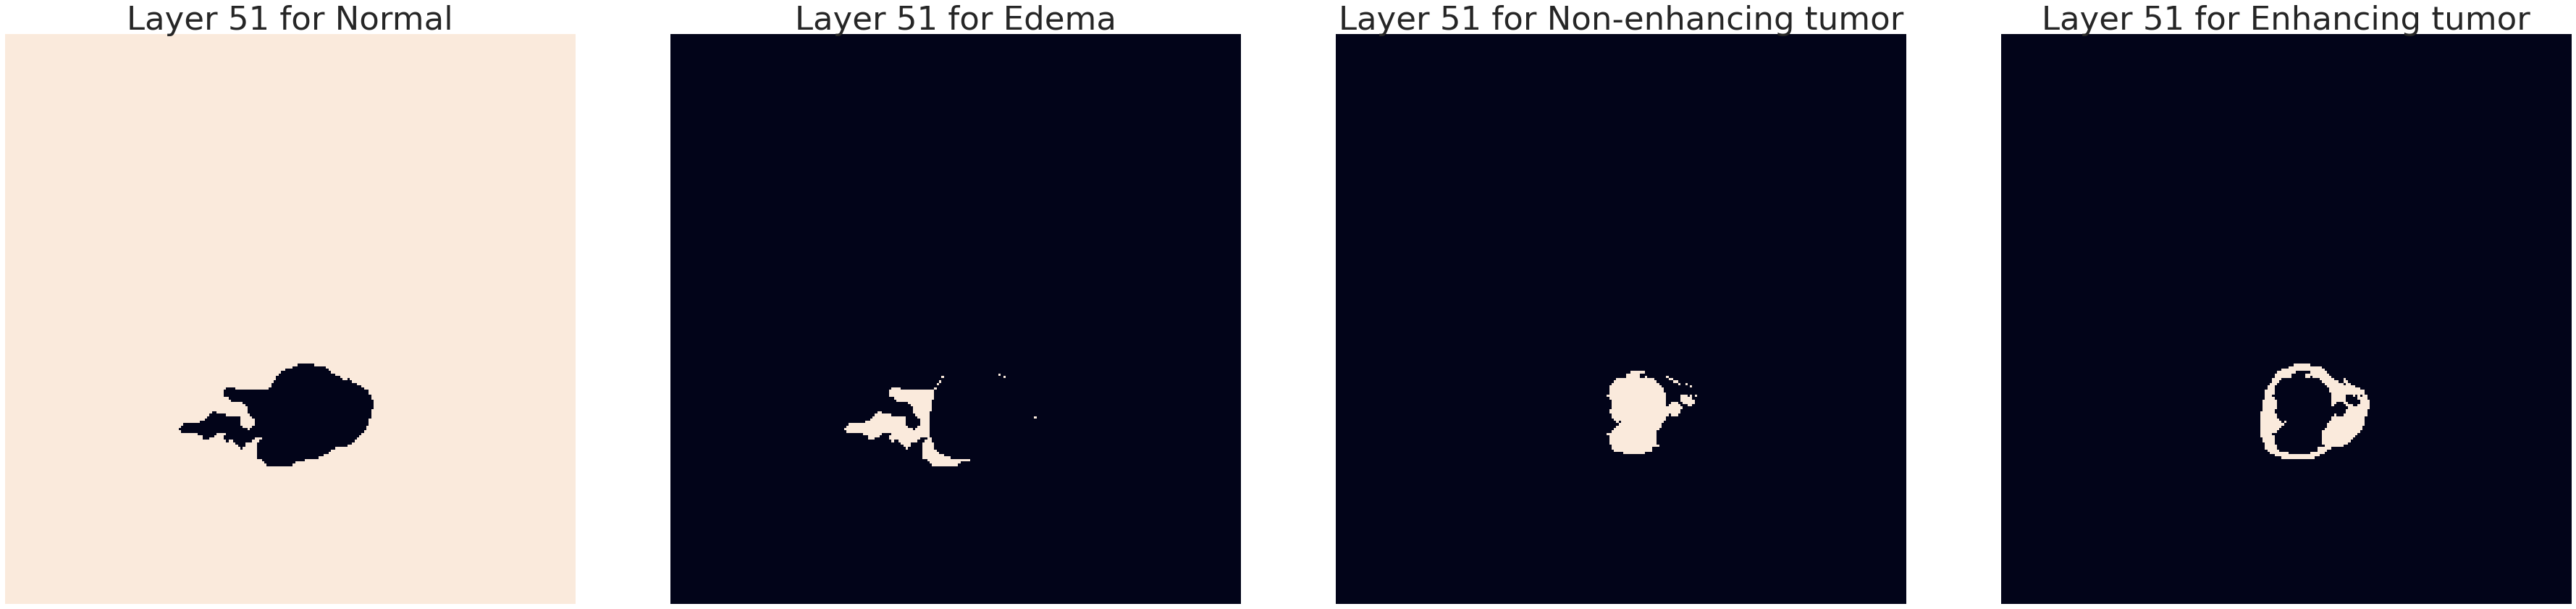

In [ ]:
layer = 51      #@param {type:"slider", min:0, max:100, step:1}

# Define a dictionary of class labels
classes_dict = {
    'Normal': 0.,
    'Edema': 1.,
    'Non-enhancing tumor': 2.,
    'Enhancing tumor': 3. 
}

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(50, 30))
for i in range(4):
    img_label_str = list(classes_dict.keys())[i]
    img = label_array[:,:,layer]
    mask = np.where(img == classes_dict[img_label_str], 255, 0)
    ax[i].imshow(mask)
    ax[i].set_title(f"Layer {layer} for {img_label_str}", fontsize=45)
    ax[i].axis('off')
plt.tight_layout()

In [ ]:
# Create button values
select_class = ToggleButtons(
    options=['Normal','Edema', 'Non-enhancing tumor', 'Enhancing tumor'],
    description='Select Class:',
    disabled=False,
    button_style='info', 
    
)

# Create layer slider
select_layer = IntSlider(min=0, max=154, description='Select Layer', continuous_update=False)
    
# Define a function for plotting images
def plot_image(seg_class, layer):
    print(f"Plotting {layer} Layer Label: {seg_class}")
    img_label = classes_dict[seg_class]
    mask = np.where(label_array[:,:,layer] == img_label, 255, 0)
    plt.figure(figsize=(10,5))
    plt.imshow(mask, cmap='gray')
    plt.axis('off');

# Use the interactive() tool to create the visualization
interactive(plot_image, seg_class=select_class, layer=select_layer)

interactive(children=(ToggleButtons(button_style='info', description='Select Class:', options=('Normal', 'Edem…

# .nii to Tensor data coverstion

In [ ]:
import cv2
import random
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt

import torch
import torch.utils

# Load file and Extract the data as a numpy array

In [ ]:
DATA_DIR = '/content/drive/MyDrive/Masters_Project/Datasets/medicaldecathlon/Task01_BrainTumour/'

# This will return numpy array
def load_case(image_nifty_file, label_nifty_file):
    image = np.array(nib.load(image_nifty_file).get_fdata())
    label = np.array(nib.load(label_nifty_file).get_fdata())
    return image, label

# Data Preprocessing

In [ ]:
import numpy as np
from keras.utils import to_categorical

def get_sub_volume(image, label, 
                   orig_x = 240, orig_y = 240, orig_z = 155, 
                   output_x = 160, output_y = 160, output_z = 16,
                   num_classes = 4, max_tries = 1000, background_threshold = 0.95):
    X = None
    y = None
    tries = 0

    while tries < max_tries:
        # randomly sample sub-volume by sampling the corner voxel
        start_x = np.random.randint(orig_x - output_x + 1)
        start_y = np.random.randint(orig_y - output_y + 1)
        start_z = np.random.randint(orig_z - output_z + 1)

        # extract relevant area of label
        y = label[start_x: start_x + output_x,
                  start_y: start_y + output_y,
                  start_z: start_z + output_z]

        y = to_categorical(y, num_classes)          # (output_x, output_y, output_z, num_classes)

        bgrd_ratio = y[:, :, :, 0].sum() / (output_x * output_y * output_z)             # compute the background ratio

        tries += 1

        if (bgrd_ratio < background_threshold):

            X = np.copy(image[start_x: start_x + output_x,
                              start_y: start_y + output_y,
                              start_z: start_z + output_z, :])
            X = np.moveaxis(X, -1, 0)       # (num_channels, x_dim, y_dim, z_dim)
            y = np.moveaxis(y, -1, 0)       # (num_classes, x_dim, y_dim, z_dim)
            y = y[1:, :, :, :]              # take a subset of y that excludes the background class
    
            return X, y

In [ ]:
# Standardization

def standardize(image):

    standardized_image = np.zeros(image.shape)
    # iterate over channels
    for c in range(image.shape[0]):
        for z in range(image.shape[3]):

            image_slice = image[c,:,:,z]                 # get a slice of the image at channel 'c' and z-th dimension 'z'
            centered = image_slice - image_slice.mean()
            if np.std(centered) != 0:
                centered_scaled = image_slice / image_slice.std()
                standardized_image[c, :, :, z] = centered_scaled

    return standardized_image

# Data Conversion

In [ ]:
def create_dataset(data_dir, patches=100):

    idx = random.sample(list(range(1,484)), patches)
    images = []
    labels = []

    for i in idx:

        if i<10:
            i = 'BRATS_00' + str(i) + '.nii.gz'
        elif i>=10 and i<100:
            i = 'BRATS_0' + str(i) + '.nii.gz'
        elif i>=100:
            i = 'BRATS_' + str(i) + '.nii.gz'

        image, label = load_case(data_dir + 'imagesTr/' + i,
                                 data_dir + 'labelsTr/' + i)

        try: 
            X,y = get_sub_volume(image, label)
            X = standardize(X)
            images.append(X)
            labels.append(y)
        except:
            continue

    return images, labels

# Save converted data

In [ ]:
images,labels = create_dataset(DATA_DIR, patches=200)

In [ ]:
print('Length of data : ', len(images))
print('Shape of each image : ', images[0].shape)
print('Shape of each label : ', labels[0].shape)

Length of data :  165
Shape of each image :  (4, 160, 160, 16)
Shape of each label :  (3, 160, 160, 16)


In [ ]:
# change datatype as 'FloatTensor'

images = torch.FloatTensor(images)
labels = torch.FloatTensor(labels)

In [ ]:
print('Length of data : ', len(images))
print('Shape of each image : ', images[0].shape)
print('Shape of each label : ', labels[0].shape)

Length of data :  165
Shape of each image :  torch.Size([4, 160, 160, 16])
Shape of each label :  torch.Size([3, 160, 160, 16])


In [ ]:
torch.save(images,'/content/drive/MyDrive/Masters_Project/Datasets/medicaldecathlon/Task01_BrainTumour/TensorData/X.pt')
torch.save(labels,'/content/drive/MyDrive/Masters_Project/Datasets/medicaldecathlon/Task01_BrainTumour/TensorData/y.pt')

In [ ]:
import cv2
import imageio
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import to_categorical

from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data.sampler import SubsetRandomSampler 


# ------ Get Label Image ------#

def get_labeled_image(image, label, is_categorical=False):
    if not is_categorical:
        label = to_categorical(label, num_classes=4).astype(np.uint8)

    image = cv2.normalize(image[:, :, :, 0], None, alpha=0, beta=255,
                          norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F).astype(
        np.uint8)

    labeled_image = np.zeros_like(label[:, :, :, 1:])

    # remove tumor part from image
    labeled_image[:, :, :, 0] = image * (label[:, :, :, 0])
    labeled_image[:, :, :, 1] = image * (label[:, :, :, 0])
    labeled_image[:, :, :, 2] = image * (label[:, :, :, 0])

    # color labels
    labeled_image += label[:, :, :, 1:] * 255
    return labeled_image



# ------ DataGenerator ------#

def DataGenerator(X, y, batch_size=6, valid_size=0.3):
    dataset = TensorDataset(X, y)
    len_dataset = len(dataset)

    indices = list(range(len_dataset))
    np.random.shuffle(indices)
    split = int(np.floor(valid_size * len_dataset))
    train_idx, valid_idx = indices[split:], indices[:split]

    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = DataLoader(dataset, batch_size = batch_size, sampler=train_sampler)
    valid_loader = DataLoader(dataset, batch_size = batch_size, sampler=valid_sampler)

    return train_loader, valid_loader


# ------ For Visualization ------#

def plot_image_grid(image):
    data_all = []

    data_all.append(image)

    fig, ax = plt.subplots(3, 6, figsize=[16, 9])

    # coronal plane
    coronal = np.transpose(data_all, [1, 3, 2, 4, 0])
    coronal = np.rot90(coronal, 1)

    # transversal plane
    transversal = np.transpose(data_all, [2, 1, 3, 4, 0])
    transversal = np.rot90(transversal, 2)

    # sagittal plane
    sagittal = np.transpose(data_all, [2, 3, 1, 4, 0])
    sagittal = np.rot90(sagittal, 1)

    for i in range(6):
        n = np.random.randint(coronal.shape[2])
        ax[0][i].imshow(np.squeeze(coronal[:, :, n, :]))
        ax[0][i].set_xticks([])
        ax[0][i].set_yticks([])
        if i == 0:
            ax[0][i].set_ylabel('Coronal', fontsize=15)

    for i in range(6):
        n = np.random.randint(transversal.shape[2])
        ax[1][i].imshow(np.squeeze(transversal[:, :, n, :]))
        ax[1][i].set_xticks([])
        ax[1][i].set_yticks([])
        if i == 0:
            ax[1][i].set_ylabel('Transversal', fontsize=15)

    for i in range(6):
        n = np.random.randint(sagittal.shape[2])
        ax[2][i].imshow(np.squeeze(sagittal[:, :, n, :]))
        ax[2][i].set_xticks([])
        ax[2][i].set_yticks([])
        if i == 0:
            ax[2][i].set_ylabel('Sagittal', fontsize=15)

    fig.subplots_adjust(wspace=0, hspace=0)


def visualize_data_gif(data_):
    images = []
    for i in range(data_.shape[0]):
        x = data_[min(i, data_.shape[0] - 1), :, :]
        y = data_[:, min(i, data_.shape[1] - 1), :]
        z = data_[:, :, min(i, data_.shape[2] - 1)]
        img = np.concatenate((x, y, z), axis=1)
        images.append(img)
    imageio.mimsave("/tmp/gif.gif", images, duration=0.01)
    return Image(filename="/tmp/gif.gif", format='png')


def visualize_patch(X, y):
    fig, ax = plt.subplots(1, 2, figsize=[10, 5], squeeze=False)

    ax[0][0].imshow(X[:, :, 0], cmap='Greys_r')
    ax[0][0].set_yticks([])
    ax[0][0].set_xticks([])
    ax[0][1].imshow(y[:, :, 0], cmap='Greys_r')
    ax[0][1].set_xticks([])
    ax[0][1].set_yticks([])

    fig.subplots_adjust(wspace=0, hspace=0)

# Model

In [ ]:

import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch import nn, optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
X = torch.load('/content/drive/MyDrive/Masters_Project/Datasets/medicaldecathlon/Task01_BrainTumour/TensorData/X.pt')
y = torch.load('/content/drive/MyDrive/Masters_Project/Datasets/medicaldecathlon/Task01_BrainTumour/TensorData/y.pt')

train_loader, valid_loader = DataGenerator(X, y, batch_size=8, valid_size=0.3)

In [ ]:
print(len(train_loader.sampler))
print(len(valid_loader.sampler))

116
49


In [ ]:
def conv_block(in_chan, out_chan, final_layer=False):
    if not final_layer:
        return nn.Sequential(
            nn.Conv3d(in_chan, out_chan, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(out_chan),
            nn.ReLU(inplace=True))
    else:
        return nn.Sequential(
            nn.Conv3d(in_chan, out_chan, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(out_chan))

In [ ]:
class Unet3D(nn.Module):

    def __init__(self, in_chan, out_chan, filters):
        super(Unet3D, self).__init__()

        self.in_chan = in_chan
        self.out_chan = out_chan
        self.filters = filters

        # Encoder
        self.conv_1 = conv_block(self.in_chan, self.filters * 1)
        self.conv_2 = conv_block(self.filters * 1, self.filters * 2)
        self.conv_3 = conv_block(self.filters * 2, self.filters * 4)

        self.conv_1_1 = conv_block(filters * 1, filters * 1)
        self.conv_2_1 = conv_block(filters * 2, filters * 2)
        self.conv_3_1 = conv_block(filters * 4, filters * 4)

        self.max_pool = nn.MaxPool3d(kernel_size=2, stride=2)

        # Bottel-neck
        self.bottel_neck = conv_block(self.filters * 4, self.filters * 8)
        self.dropout = nn.Dropout3d(0.3)

        # Decoder
        self.upsample = nn.Upsample(scale_factor=(2.0, 2.0, 2.0), mode='nearest')
        self.dconv_1 = conv_block(self.filters * 12, self.filters * 4)
        self.dconv_2 = conv_block(self.filters * 6, self.filters * 2)
        self.dconv_3 = conv_block(self.filters * 3, self.filters * 1)

        # Output and Conv_block
        self.output = conv_block(self.filters * 1, self.out_chan, final_layer=True)

    def forward(self, x):

        # Down Sampling
        conv1 = self.conv_1_1(self.conv_1(x))                                         # (:, 16, :, :, :)
        conv2 = self.conv_2_1(self.conv_2(self.max_pool(conv1)))                      # (:, 32, :, :, :)
        conv3 = self.conv_3_1(self.conv_3(self.dropout(self.max_pool(conv2))))        # (:, 64, :, :, :)

        # Bottel-neck
        bottelneck = self.bottel_neck(self.max_pool(conv3))                           # (:, 128, :, :, :)

        # Up Sampling
        upconv1 = self.upsample(bottelneck)                                           # (:, 128, :, :, :)
        upconv1 = torch.cat([upconv1, conv3], dim=1)                                  # (:, 192, :, :, :)
        upconv1 = self.dconv_1(upconv1)                                               # (:, 64, :, :, :)

        upconv2 = self.upsample(upconv1)                                              # (:, 64, :, :, :)
        upconv2 = torch.cat([upconv2, conv2], dim=1)                                  # (:, 96, :, :, :)
        upconv2 = self.dconv_2(self.dropout(upconv2))                                 # (:, 32, :, :, :)

        upconv3 = self.upsample(upconv2)                                              # (:, 32, :, :, :)
        upconv3 = torch.cat([upconv3, conv1], dim=1)                                  # (:, 48, :, :, :)
        upconv3 = self.dconv_3(upconv3)                                               # (:, 16, :, :, :)

        out = F.logsigmoid(self.output(upconv3))                                      # (:, 3, :, :, :)

        return out

In [ ]:
model = Unet3D(in_chan=4, out_chan=3, filters=16)
model.to(device)

Unet3D(
  (conv_1): Sequential(
    (0): Conv3d(4, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv_2): Sequential(
    (0): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv_3): Sequential(
    (0): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv_1_1): Sequential(
    (0): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv_2_1): Sequential(
    (0): Conv3d(32, 32, kernel_size=(3, 3, 3), st

In [ ]:
def dice_coefficient(y_true, y_pred, axis=(1, 2, 3), epsilon=0.00001):
    dice_numerator = (2.0 * torch.sum(y_pred * y_true, axis=axis)) + epsilon
    dice_denominator = torch.sum(y_pred, dim=axis) + torch.sum(y_true, dim=axis) + epsilon
    dice_coefficient = torch.mean(dice_numerator / dice_denominator)
    return dice_coefficient

def soft_dice_loss(y_true, y_pred, axis=(1, 2, 3), epsilon=0.00001):
    dice_numerator = (2.0 * torch.sum(y_pred * y_true, axis=axis)) + epsilon
    dice_denominator = torch.sum(y_pred**2, dim=axis) + torch.sum(y_true**2, dim=axis) + epsilon
    dice_loss = 1 - torch.mean(dice_numerator / dice_denominator)
    return dice_loss

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.1)

In [ ]:
epochs = 50
hist_train_loss = []
hist_val_loss = []

hist_train_dice = []
hist_val_dice = []

valid_loss_min = np.Inf

In [ ]:
for epoch in range(epochs):

    train_loss = 0.0
    val_loss = 0.0
    train_dice = 0.0
    val_dice = 0.0

    model.train()
    for images,labels in train_loader:

        images = images.cuda()
        labels = labels.cuda()

        optimizer.zero_grad()
        logps = model(images)
        ps = torch.exp(logps)

        dice = dice_coefficient(labels, ps)
        loss = soft_dice_loss(labels, ps)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()*images.size(0)
        train_dice += dice.item()*images.size(0)
        
    model.eval()
    with torch.no_grad():
        for images,labels in valid_loader:

            images = images.cuda()
            labels = labels.cuda()

            logps = model(images)
            ps = torch.exp(logps)

            dice = dice_coefficient(labels, ps)
            loss = soft_dice_loss(labels,ps)        
            val_loss += loss.item()*images.size(0)
            val_dice += dice.item()*images.size(0)
    
    train_loss = train_loss / len(train_loader.sampler)
    val_loss = val_loss / len(valid_loader.sampler)
    train_dice = train_dice / len(train_loader.sampler)
    val_dice = val_dice / len(valid_loader.sampler)

    hist_train_loss.append(train_loss)
    hist_val_loss.append(val_loss)
    hist_train_dice.append(train_dice)
    hist_val_dice.append(val_dice)

    print("\nEpoch : {} \ntraining Loss : {:.6f}, \tTrain_dice : {:.6f}, \nValidation Loss : {:.6f}, \tVal_dice : {:.6f}".format(epoch + 1, 
                                                                                                                    train_loss, train_dice,
                                                                                                                    val_loss, val_dice))
    if val_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).\nSaving model ...'.format(valid_loss_min,val_loss))
        torch.save(model.state_dict(), 'TumorSegmentation.pt')
        valid_loss_min = val_loss


Epoch : 1 
training Loss : 0.753534, 	Train_dice : 0.121496, 
Validation Loss : 0.950004, 	Val_dice : 0.049807
Validation loss decreased (inf --> 0.950004).
Saving model ...

Epoch : 2 
training Loss : 0.517229, 	Train_dice : 0.253770, 
Validation Loss : 0.797174, 	Val_dice : 0.160072
Validation loss decreased (0.950004 --> 0.797174).
Saving model ...

Epoch : 3 
training Loss : 0.442693, 	Train_dice : 0.351976, 
Validation Loss : 0.716915, 	Val_dice : 0.230310
Validation loss decreased (0.797174 --> 0.716915).
Saving model ...

Epoch : 4 
training Loss : 0.417432, 	Train_dice : 0.393308, 
Validation Loss : 0.486486, 	Val_dice : 0.364050
Validation loss decreased (0.716915 --> 0.486486).
Saving model ...

Epoch : 5 
training Loss : 0.419591, 	Train_dice : 0.397507, 
Validation Loss : 0.666474, 	Val_dice : 0.247727

Epoch : 6 
training Loss : 0.422297, 	Train_dice : 0.399751, 
Validation Loss : 0.525427, 	Val_dice : 0.343120

Epoch : 7 
training Loss : 0.406358, 	Train_dice : 0.410201,

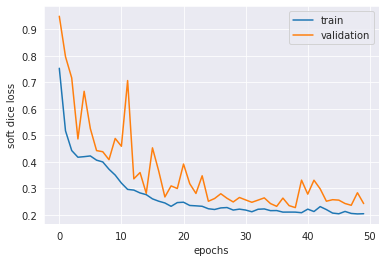

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.plot(hist_train_loss, label='train')
plt.plot(hist_val_loss, label='validation')
plt.xlabel('epochs')
plt.ylabel('soft dice loss')
plt.legend()
plt.show()

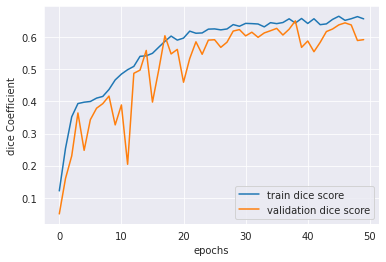

In [ ]:
plt.plot(hist_train_dice,label='train dice score')
plt.plot(hist_val_dice,label='validation dice score')
plt.xlabel('epochs')
plt.ylabel('dice Coefficient')
plt.legend()
plt.show()

In [ ]:
pred_y = model(torch.unsqueeze(X[55].cuda(), 0))
pred_y = torch.exp(pred_y)
pred_y.shape

torch.Size([1, 3, 160, 160, 16])

In [ ]:
pred_y = torch.squeeze(pred_y, 0)
pred_y = pred_y.cpu().detach().numpy()

In [ ]:
true_y = y[55]
true_y = true_y.numpy()
true_y.shape

(3, 160, 160, 16)

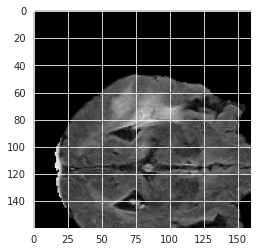

In [ ]:
plt.imshow(X[55][0,:,:,12], cmap = 'gray')

Ground truth


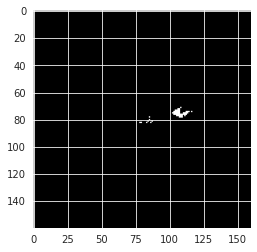

In [ ]:
print('Ground truth')
plt.imshow(true_y[1,:,:,12],cmap = 'gray')

Prediction


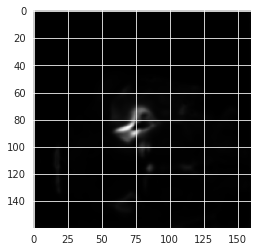

In [ ]:
print('Prediction')
plt.imshow(pred_y[1,:,:,12],cmap = 'gray')